In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

base_path = '/kaggle/input/week-7-brain-tumor-classification-challenge/'
print("Top-level contents:")
for item in os.listdir(base_path):
    print(item)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Top-level contents:
Brain_Tumor
sample_submission.csv
train.csv
test.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [3]:
import pandas as pd

base_path = '/kaggle/input/week-7-brain-tumor-classification-challenge'
train_csv_path = f'{base_path}/train.csv'

train_df = pd.read_csv(train_csv_path)
print("Columns in train.csv:", train_df.columns)
print(train_df.head())

Columns in train.csv: Index(['image_name', 'label'], dtype='object')
       image_name  label
0  Tr-gl_0419.jpg      0
1  Tr-gl_0264.jpg      0
2  Tr-gl_0296.jpg      0
3  Tr-gl_0438.jpg      0
4  Tr-gl_0141.jpg      0


In [4]:
from torchvision import datasets
from PIL import Image
from collections import Counter
import os

# Path to the structured training folder
data_dir = '/kaggle/input/week-7-brain-tumor-classification-challenge/Brain_Tumor/Brain_Tumor/Training'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir)

# Class names and their order
print("Class names:", dataset.classes)

# Count images per class
class_counts = Counter([label for _, label in dataset.samples])
print(f"\nClass distribution: {class_counts}")

# Show image sizes
print("\nImage sizes (first 5):")
for i in range(5):
    img_path, label = dataset.samples[i]
    with Image.open(img_path) as img:
        print(f"Image {i}: {img.size} (Class: {dataset.classes[label]})")

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Class distribution: Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})

Image sizes (first 5):
Image 0: (512, 512) (Class: glioma)
Image 1: (512, 512) (Class: glioma)
Image 2: (512, 512) (Class: glioma)
Image 3: (512, 512) (Class: glioma)
Image 4: (512, 512) (Class: glioma)


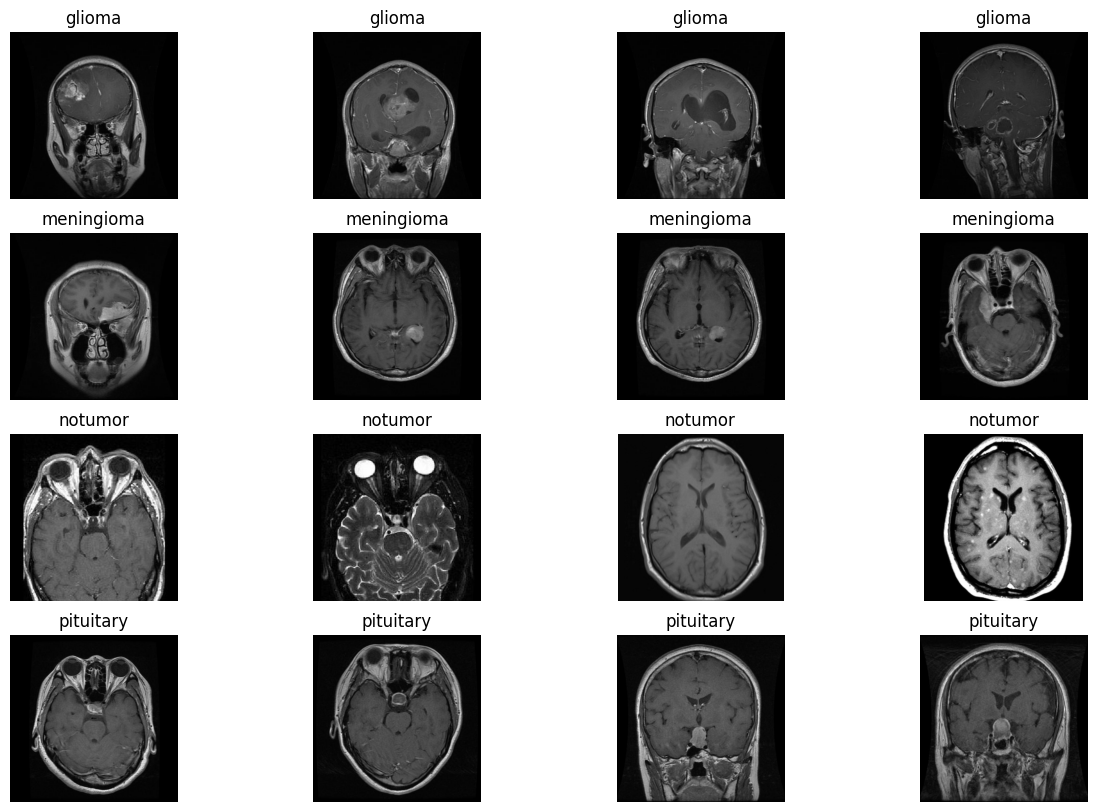

In [5]:
# Function to plot samples
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 10))
    for i, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if label == i]
        for j in range(num_samples):
            img_path, _ = dataset.samples[class_indices[j]]
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    plt.show()

# Display samples
plot_samples(dataset)
    

Training images: 5712
Training dataset Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing images: 1311


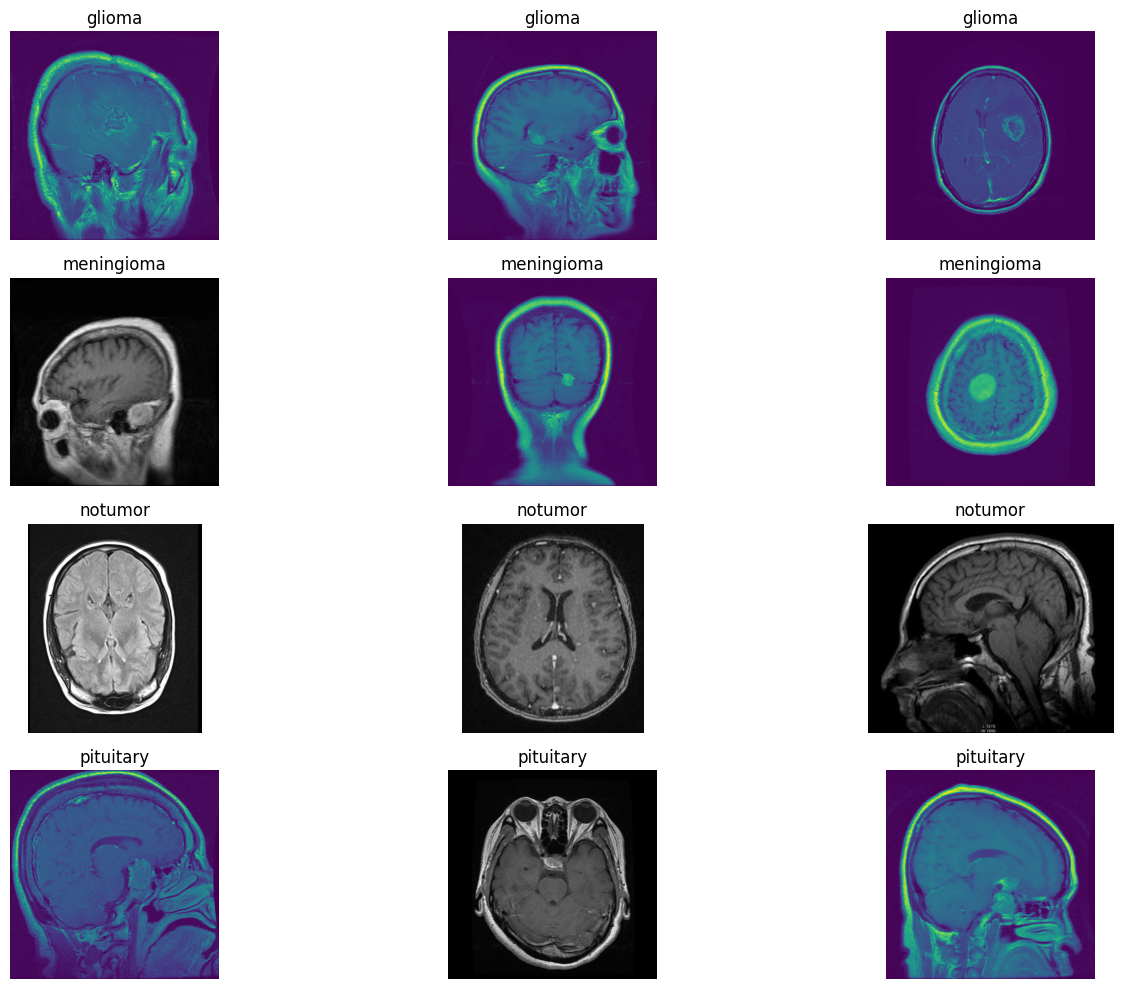

In [6]:
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os

# Define the correct dataset paths
data_dir_training = '/kaggle/input/week-7-brain-tumor-classification-challenge/Brain_Tumor/Brain_Tumor/Training'
data_dir_testing = '/kaggle/input/week-7-brain-tumor-classification-challenge/Brain_Tumor/Brain_Tumor/Testing'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load training dataset using ImageFolder
dataset_training = datasets.ImageFolder(root=data_dir_training, transform=transform)

# Explore the dataset
print(f'Training images: {len(dataset_training)}')
print(f'Training dataset Classes: {dataset_training.classes}')

# Since testing folder has no class folders, we just count files manually
test_img_files = list(Path(data_dir_testing).glob('*.jpg')) + list(Path(data_dir_testing).glob('*.png'))
print(f'Testing images: {len(test_img_files)}')

# Visualize sample images from the training dataset
train_dir = Path(data_dir_training)
class_names = dataset_training.classes

plt.figure(figsize=(15, 10))

# Show 3 random images from each class
for i, class_name in enumerate(class_names, 1):
    class_path = train_dir / class_name
    image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))

    selected_images = random.sample(image_files, min(3, len(image_files)))

    for j, img_path in enumerate(selected_images, 1):
        ax = plt.subplot(4, 3, (i - 1) * 3 + j)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import os

# Define transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load training dataset using ImageFolder and apply transform
data_dir_training = '/kaggle/input/week-7-brain-tumor-classification-challenge/Brain_Tumor/Brain_Tumor/Training'
dataset_training = datasets.ImageFolder(root=data_dir_training, transform=train_transform)

# Custom Dataset for unlabeled test images
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.image_paths = list(self.image_dir.glob('*.jpg')) + list(self.image_dir.glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path.name  # return filename for submission

# Load the test set using the custom dataset
data_dir_testing = '/kaggle/input/week-7-brain-tumor-classification-challenge/Brain_Tumor/Brain_Tumor/Testing'
dataset_testing = TestImageDataset(image_dir=data_dir_testing, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(dataset_training, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_testing, batch_size=32, shuffle=False)

In [8]:
batch_size = 32
epochs = 25
learning_rate = 0.001

In [9]:

class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)  # 4-class classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = TumorClassifier()

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

# Define loss and optimizer
learning_rate = 0.001  # Make sure this is defined before use
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

TumorClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [10]:
# Ensure you defined 'device' earlier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to CPU or GPU

        optimizer.zero_grad()           # Clear gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/25, Loss: 0.6400
Epoch 2/25, Loss: 0.3429
Epoch 3/25, Loss: 0.2497
Epoch 4/25, Loss: 0.1946
Epoch 5/25, Loss: 0.1551
Epoch 6/25, Loss: 0.1193
Epoch 7/25, Loss: 0.0904
Epoch 8/25, Loss: 0.0669
Epoch 9/25, Loss: 0.0677
Epoch 10/25, Loss: 0.0502
Epoch 11/25, Loss: 0.0477
Epoch 12/25, Loss: 0.0352
Epoch 13/25, Loss: 0.0400
Epoch 14/25, Loss: 0.0358
Epoch 15/25, Loss: 0.0346
Epoch 16/25, Loss: 0.0221
Epoch 17/25, Loss: 0.0229
Epoch 18/25, Loss: 0.0349
Epoch 19/25, Loss: 0.0190
Epoch 20/25, Loss: 0.0114
Epoch 21/25, Loss: 0.0162
Epoch 22/25, Loss: 0.0134
Epoch 23/25, Loss: 0.0215
Epoch 24/25, Loss: 0.0251
Epoch 25/25, Loss: 0.0176


In [11]:
# Set model to evaluation mode
model.eval()

# Store predictions as (image_name, predicted_label)
predictions = []

# No gradient calculation needed during inference
with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect results
        for fname, label in zip(filenames, predicted.cpu().numpy()):
            predictions.append([fname, label])

# Create submission DataFrame
submission_df = pd.DataFrame(predictions, columns=['image_name', 'label'])

# Optional: sort by image name (recommended for consistency)
submission_df = submission_df.sort_values(by='image_name').reset_index(drop=True)

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("Saved submission.csv successfully.")

Saved submission.csv successfully.
